# N-Armed Bandit Problem 


### Installation 

Gym에서 기본적으로 제공해주는 Environment가 없지만, 다행히도 JKCooper2라는 사람이 Environment를 만들었습니다.<br>
아래는 설치 방법.. 

```
git clone git@github.com:JKCooper2/gym-bandits.git
cd gym-bandits
pip install -e .
```

### N-Armed Bandit Problem

한글로 하면 여러손이 달린 강도인데.. 슬롯머신이 옛날 이름입니다. <br>
알고리즘은 Explotation 그리고 Exploration 둘중 어느것을 택할 것인지에 관한 문제가 핵심 입니다. <br>
여러 방법들이 있습니다.<br>

* epsilon을 계속 고정적으로 두는 방법 
* decay를 사용하여 학습과 함께 점점 줄어드는 방법 (즉 처음에는 random하게 action을 선택을 많이 하지만 나중에는 greedy사용)
* 언제부터 greedy를 사용할것인지.. (처음 200번은 무조건 랜덤하게만 선택)
* 기타등등

이런것에 따라서 같은 학습을 하더라도 최종 결과가 많이 달라질수 있습니다.<br>
아래 예제에서는 서로 모든것이 동일하지만.. epsilon의 값이 다르면, 최종 rewards값이 달라질수 있음을 보여주는 예제 입니다.

In [193]:
%pylab inline
import gym
import gym_bandits
import numpy as np
import pylab as plt

Populating the interactive namespace from numpy and matplotlib


In [442]:
def visualize(rewards, epsilons, axarr=None, color=None, label=None, linestyle='-'):
    if axarr is None:
        figure, axarr = plt.subplots(2, sharex=False)
    axarr[0].plot(rewards, color=color, label=label, linestyle=linestyle)
    axarr[0].grid()
    axarr[0].set_ylabel('rewards')
    axarr[0].set_xlabel('the number of plays')
    axarr[0].legend(loc='upper center')
    
    axarr[1].set_xlabel('the number of plays')
    axarr[1].set_ylabel('epsilons')
    axarr[1].plot(epsilons, color=color, label=label, linestyle=linestyle)
    axarr[1].grid()
    axarr[1].legend(loc='upper center')
    
    return axarr
    

In [533]:
class Env(object):
    def __init__(self, epsilon=0.1, start_step=0, total_step=2000):
        self.env = gym.make("BanditTenArmedGaussian-v0")
        self.init(epsilon, start_step, total_step)
        
    def init(self, epsilon, start_step, total_step):
        self.counts = np.zeros(self.env.action_space.n)
        self.values = np.zeros(self.env.action_space.n)
        self._epsilon = epsilon
        self.total_step = total_step
        self.start_step = start_step
        
        self.step = 0
        
    def again(self, epsilon=0.1, start_step=0, total_step=2000):
        self.init(epsilon, start_step, total_step)
        
    def restart(self):
        self.env.reset()
        

class Bandit(Env):
    def train(self):
        prev_reward = 0
        total_rewards = []
        total_epsilons = []
        for self.step in range(self.total_step):
            action = self.choose_arm()
            state, reward, done, option = self.env.step(action)
            self.update(action, reward)
            
            # For Plotting
            prev_reward += reward
            total_rewards.append(prev_reward)
            total_epsilons.append(self.epsilon)
        return total_rewards, total_epsilons
    
    def choose_arm(self):
        if self.start_step < self.step and np.random.random() > self.epsilon:
            # Exploitation
            return np.argmax(self.values)
        else:
            # Exploration 
            return np.random.randint(self.env.action_space.n)
        
    def update(self, action, reward):
        self.counts[action] += 1
        n = self.counts[action]
        v = self.values[action]
        
        new_v = (n - 1.)/float(n) * v + (reward/float(n))
        self.values[action] = new_v
        
    @property
    def epsilon(self):
        return self.start_step*0.5/float(self.step + self.start_step*0.5) + self._epsilon
        

[2016-12-13 16:18:48,971] Making new env: BanditTenArmedGaussian-v0


values: [-3.05474081 -1.99994351  2.28247853 -1.7773952  -0.26174165  0.37533612
  0.84136015  1.19261298  0.13522196 -1.44527498]


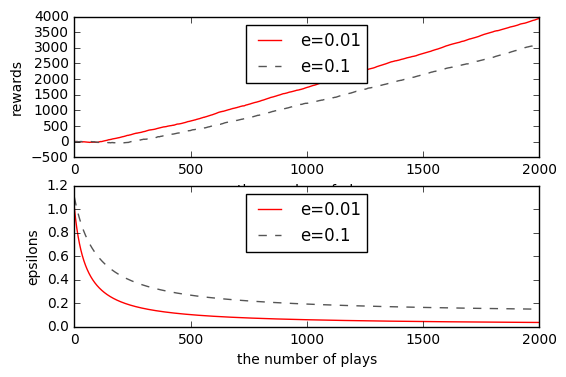

In [532]:
bandit = Bandit(epsilon=0.01, start_step=100, total_step=2000)
total_rewards, total_epsilons = bandit.train()
axarr = visualize(total_rewards, total_epsilons, color='red', label='e=0.01', linestyle='-')

# bandit = Bandit(epsilon=0.1, start_step=100)
bandit.again(epsilon=0.1, start_step=200, total_step=2000)
total_rewards, total_epsilons = bandit.train()
visualize(total_rewards, total_epsilons, axarr=axarr, color='#555555', label='e=0.1', linestyle='--')
print 'values:', bandit.values